#Creation of a model for horse classification.

In [ ]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 719 kB 12.1 MB/s 
     |████████████████████████████████| 197 kB 49.3 MB/s 
     |████████████████████████████████| 1.2 MB 37.8 MB/s 
     |████████████████████████████████| 59 kB 6.5 MB/s 
Mounted at /content/gdrive


In [ ]:
#hide
import fastai
from fastbook import *
from ipywidgets import *
from fastai.vision.all import *
from fastai.vision.widgets import *

In [ ]:
def search_images_ddg(term, max_images=200):
    assert max_images<1000
    url = 'https://duckduckgo.com/'
    res = urlread(url,data={'q':term}, decode=False).decode()
    searchObj = re.search(r'vqd=([\d-]+)\&', res)
    assert searchObj
    requestUrl = url + 'i.js'
    params = dict(l='us-en', o='json', q=term, vqd=searchObj.group(1), f=',,,', p='1', v7exp='a')
    urls,data = set(),{'next':1}
    while len(urls)<max_images and 'next' in data:
        try:
            data = urljson(requestUrl,data=params)
            urls.update(L(data['results']).itemgot('image'))
            requestUrl = url + data['next']
        except (URLError,HTTPError): pass
        time.sleep(0.2)
    return L(urls)
urls = search_images_ddg('black horse', max_images=100)

In [ ]:
urls = search_images_ddg("black horse", max_images=100)
urls

(#100) ['https://wallup.net/wp-content/uploads/2015/06/Running-black-horse1.jpg','https://i2.wp.com/ihearthorses.com/wp-content/uploads/2020/01/Canva-Friesian-black-horse-with-long-mane-galloping-scaled.jpg','http://wallpapercave.com/wp/wp2019200.jpg','https://wallpapercave.com/wp/5adMmqo.jpg','http://virtualhorsegames.net/wp-content/uploads/Black-Arabian-horse.jpg','https://www.thepaws.net/wp-content/uploads/2019/03/dark-horse-names-2.jpg','http://www.hdwallpaperspulse.com/wp-content/uploads/2020/11/wonderful-Black-Horse-Wallpaper.jpg','https://cdn.shortpixel.ai/client/q_glossy,ret_img,w_1024/https://www.helpfulhorsehints.com/wp-content/uploads/black-mustang-1024x597.jpg','https://www.wildblackhorse.com/wp-content/uploads/2016/12/Mustang-horses_110716_0081t.jpg','https://athenaposters.ca/wp-content/uploads/2017/01/2400-3868-Black-Horse-Running.jpg'...]

The search for black horses Really works and was saved inside urls.

In [ ]:
urls[0]

'https://wallup.net/wp-content/uploads/2015/06/Running-black-horse1.jpg'

In [ ]:
results = search_images_ddg("black horse")
len(results)

270

we have successfully downloaded these images of black horses.

In [ ]:
#hide
ims = ['https://cmkt-image-prd.freetls.fastly.net/0.1.0/ps/1134940/1360/2095/m1/fpnw/wm1/qwktfftlcurejolsyscbcwzvxztydep41z563cnpa2o0brzcd0lymxlqa4bvpgrg-.jpg?1459412931&s=815f98e83807e7cbc83c980cfb907790']

In [ ]:
dest = 'images/black.jpg'
download_url(ims[0], dest)

Path('images/black.jpg')

When we open the image, we realize that it is in accordance with the requested:


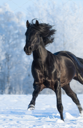

In [ ]:
im = Image.open(dest)
im.to_thumb(128,128)

We have selected different types of horses:


In [ ]:
horse_types = 'black', 'grey', 'dun'
path = Path('horse')

In [ ]:
!ls

gdrive	images	sample_data


In [ ]:
!rm -rf horse

In [ ]:
from tqdm import tqdm
if not path.exists():
    path.mkdir()
    for o in tqdm(horse_types):
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_ddg(f'{o} horse', max_images=100)
        download_images(dest, urls=results)

100%|██████████| 3/3 [00:29<00:00,  9.78s/it]


In our folder have image files, as you would expect:

In [ ]:
fns = get_image_files(path)
fns

(#283) [Path('horse/dun/00000060.jpg'),Path('horse/dun/00000085.jpg'),Path('horse/dun/00000095.jpg'),Path('horse/dun/00000063.jpg'),Path('horse/dun/00000076.jpg'),Path('horse/dun/00000020.jpg'),Path('horse/dun/00000035.png'),Path('horse/dun/00000001.jpg'),Path('horse/dun/00000023.jpg'),Path('horse/dun/00000003.jpg')...]

This is the amount of images that failed, as some files may be corrupted:

In [ ]:
failed = verify_images(fns)
failed

(#1) [Path('horse/black/00000081.jpg')]

In [ ]:
failed.map(Path.unlink);

We want to customize the creation of our DataLoaders:


In [ ]:
horse = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

we want to tell fastai the path where the images can be found:

In [ ]:
dls = horse.dataloaders(path)

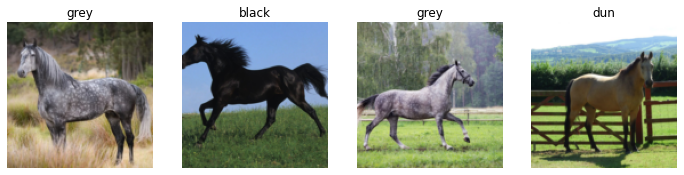

In [ ]:
dls.valid.show_batch(max_n=4, nrows=1)

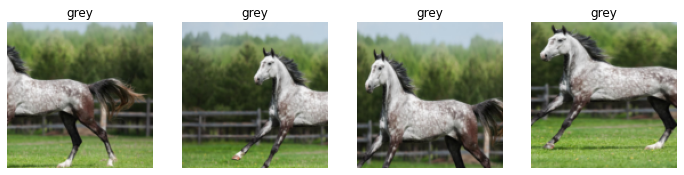

In [ ]:
horse = horse.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = horse.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

using the technique to increase the amount of data:

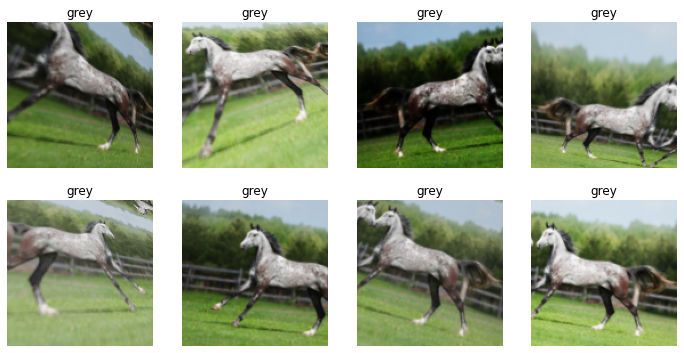

In [ ]:
horse = horse.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = horse.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [ ]:
horse = horse.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = horse.dataloaders(path)

In [ ]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:265: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.552939,0.944963,0.375000,00:15


epoch,train_loss,valid_loss,error_rate,time
0,0.683176,0.563539,0.214286,00:13
1,0.549510,0.311378,0.107143,00:13
2,0.409366,0.248352,0.071429,00:13
3,0.334819,0.219315,0.071429,00:13


we can create a confusion matrix to analyze the learning:

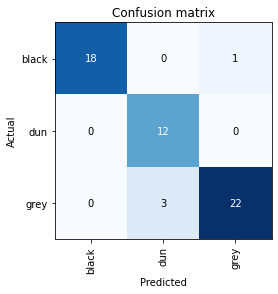

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

plot_top_losses shows us the most lossy images in our dataset:

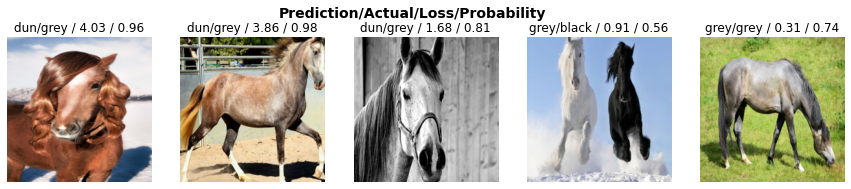

In [ ]:
interp.plot_top_losses(5, nrows=1)

In [ ]:
cleaner = ImageClassifierCleaner(learn)
cleaner

______________


To build the web App, we'll export the model and thus save the definition of how to create the Dataloaders:

In [ ]:
learn.export('horse_classifier.pkl')

In [ ]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('horse_classifier.pkl')]

Subsequently, it is necessary to create our inference learner from the exported file, we use load_learner:

In [ ]:
learn_inf = load_learner(path/'horse_classifier.pkl')

In [ ]:
learn_inf.predict('images/black.jpg')

('black', TensorBase(0), TensorBase([9.9808e-01, 1.6517e-03, 2.6416e-04]))

In [ ]:
learn_inf.dls.vocab

['black', 'dun', 'grey']

_________________________________________

Creating a notebook application from the model, using : IPython Widgets (ipywidgets) and
Voila

In [ ]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [ ]:
# For the book, we can't actually click an upload button, so we fake it
btn_upload = SimpleNamespace(data = ['images/black.jpg'])

In [ ]:
img = PILImage.create(btn_upload.data[-1])

In [ ]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

getting new predictions:

In [ ]:
pred,pred_idx,probs = learn_inf.predict(img)

and using the Label to display them:

In [ ]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: black; Probability: 0.9981')

creating a button to classify:

In [ ]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [ ]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [ ]:
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [ ]:
VBox([widgets.Label('Select your horse!'), 
      btn_upload, btn_run, out_pl, lbl_pred])